In [1]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
import math
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib.transforms as mtrans
import yaml
from yaml.loader import SafeLoader
from collections import OrderedDict
#from verstack.stratified_continuous_split import scsplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import seaborn as sns
import random as rd

/tmp/ipykernel_980322/977777567.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
acc_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv', usecols=['long_name', 'Right_PCS'])
acc_labels_present = acc_labels.loc[acc_labels['Right_PCS']=='present']
acc_labels_absent = acc_labels.loc[acc_labels['Right_PCS']=='absent']

In [3]:
model_dir = 'UMAP_ACC_UKB/random_all_keep_bottom_10/'
#model_dir = 'old_best/16-54-45_0/'

ukb_embeddings_dir = f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/{model_dir}/UKB_embeddings/full_embeddings.csv'
acc_0_embeddings_dir = f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/{model_dir}/ACC_0_embeddings/full_embeddings.csv'
acc_1_embeddings_dir = f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/{model_dir}/ACC_1_embeddings/full_embeddings.csv'

ukb_embeddings = pd.read_csv(ukb_embeddings_dir)
acc_0_embeddings = pd.read_csv(acc_0_embeddings_dir)
acc_1_embeddings = pd.read_csv(acc_1_embeddings_dir)

acc_0_PCS_embeddings = acc_0_embeddings.loc[acc_0_embeddings['ID'].isin(acc_labels_present['long_name'])]
acc_0_noPCS_embeddings = acc_0_embeddings.loc[acc_0_embeddings['ID'].isin(acc_labels_absent['long_name'])]
acc_1_PCS_embeddings = acc_1_embeddings.loc[acc_1_embeddings['ID'].isin(acc_labels_present['long_name'])]
acc_1_noPCS_embeddings = acc_1_embeddings.loc[acc_1_embeddings['ID'].isin(acc_labels_absent['long_name'])]

In [93]:
## old config from SPIE paper
model_dir = 'old_best/14-48-19_1/'

ukb_embeddings_dir = f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/{model_dir}/cing_UKB_embeddings/full_embeddings.csv'
acc_embeddings_dir = f'/volatile/jl277509/Runs/02_STS_babies/Program/Output/{model_dir}/cingulate_ACCpatterns_embeddings/full_embeddings.csv'
acc_0_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/ACCpatterns_0_without_headers.csv', header=None)
acc_1_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/ACCpatterns_1_without_headers.csv', header=None)

ukb_embeddings = pd.read_csv(ukb_embeddings_dir)
acc_embeddings = pd.read_csv(acc_embeddings_dir)

acc_0_PCS_embeddings = acc_embeddings.loc[(acc_embeddings['ID'].isin(acc_labels_present['long_name'])) | 
                                          (acc_embeddings['ID'].isin(acc_0_labels[0]))]
acc_0_noPCS_embeddings = acc_embeddings.loc[(acc_embeddings['ID'].isin(acc_labels_absent['long_name'])) |
                                            (acc_embeddings['ID'].isin(acc_0_labels[0]))]
acc_1_PCS_embeddings = acc_embeddings.loc[(acc_embeddings['ID'].isin(acc_labels_present['long_name'])) |
                                          (acc_embeddings['ID'].isin(acc_1_labels[0]))]
acc_1_noPCS_embeddings = acc_embeddings.loc[(acc_embeddings['ID'].isin(acc_labels_absent['long_name'])) |
                                            (acc_embeddings['ID'].isin(acc_1_labels[0]))]

In [4]:
# fit UMAP on UKB
reducer = umap.UMAP()
dims = [f'dim{k}' for k in range(1,11)]
X = ukb_embeddings[dims]
embeddings_ukb = reducer.fit_transform(X)

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:
embeddings_acc_0_PCS = reducer.transform(acc_0_PCS_embeddings[dims])
embeddings_acc_0_noPCS = reducer.transform(acc_0_noPCS_embeddings[dims])
embeddings_acc_1_PCS = reducer.transform(acc_1_PCS_embeddings[dims])
embeddings_acc_1_noPCS = reducer.transform(acc_1_noPCS_embeddings[dims])

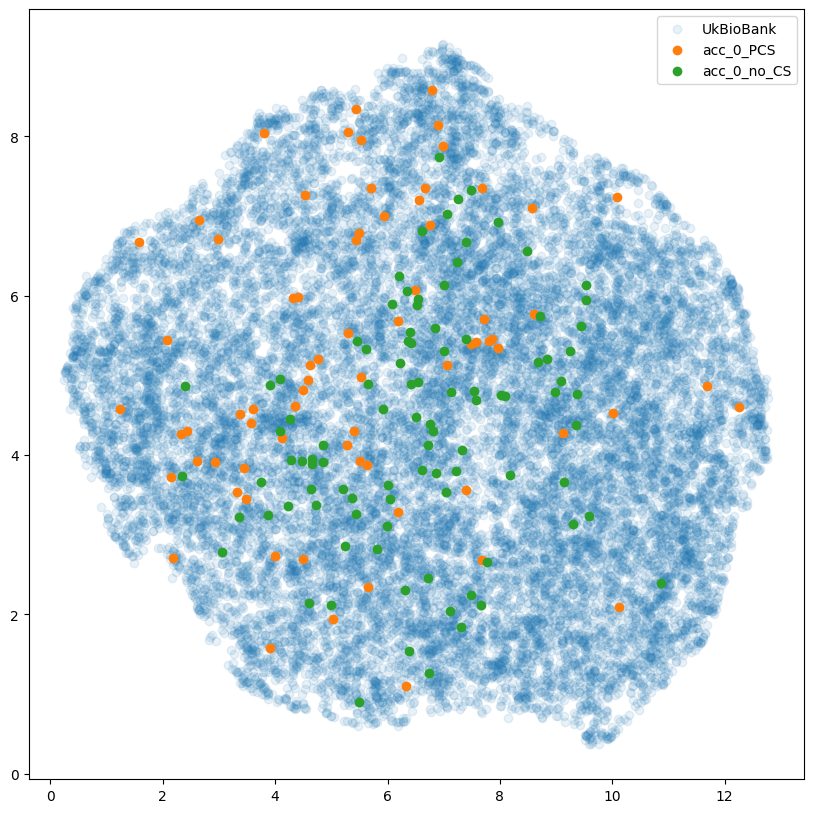

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(embeddings_ukb[:,0], embeddings_ukb[:,1], alpha=0.1, label='UkBioBank')
plt.scatter(embeddings_acc_0_PCS[:, 0], embeddings_acc_0_PCS[:, 1], label='acc_0_PCS')
plt.scatter(embeddings_acc_0_noPCS[:, 0], embeddings_acc_0_noPCS[:, 1], label='acc_0_no_CS')
#plt.scatter(embeddings_acc_1_PCS[:, 0], embeddings_acc_1_PCS[:, 1], label='acc_1_PCS')
#plt.scatter(embeddings_acc_1_noPCS[:, 0], embeddings_acc_1_noPCS[:, 1], label='acc_1_noPCS')
plt.legend()
plt.show()

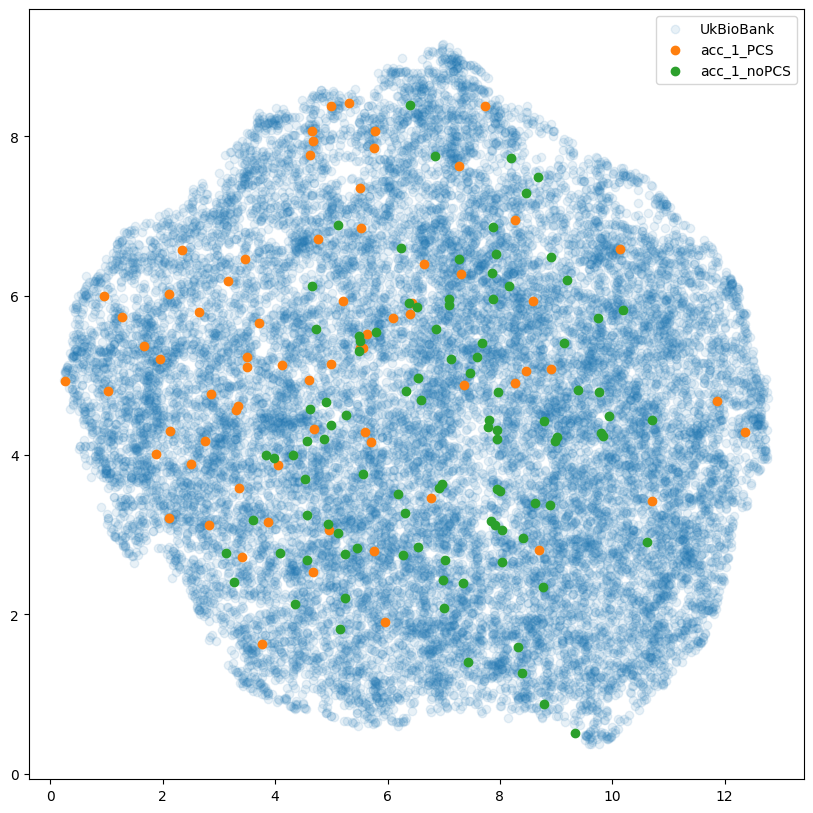

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(embeddings_ukb[:,0], embeddings_ukb[:,1], alpha=0.1, label='UkBioBank')
#plt.scatter(embeddings_acc_0_PCS[:, 0], embeddings_acc_0_PCS[:, 1], label='acc_0_PCS')
#plt.scatter(embeddings_acc_0_noPCS[:, 0], embeddings_acc_0_noPCS[:, 1], label='acc_0_no_CS')
plt.scatter(embeddings_acc_1_PCS[:, 0], embeddings_acc_1_PCS[:, 1], label='acc_1_PCS')
plt.scatter(embeddings_acc_1_noPCS[:, 0], embeddings_acc_1_noPCS[:, 1], label='acc_1_noPCS')
plt.legend()
plt.show()

In [98]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

In [99]:
# classification UKB / ACC
# from UMAP space
embeddings_acc = np.vstack((embeddings_acc_0_PCS, embeddings_acc_0_noPCS, embeddings_acc_1_PCS, embeddings_acc_1_noPCS))
x = np.vstack((embeddings_acc, embeddings_ukb))
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = [0 for k in range(len(embeddings_acc))] + [1 for k in range(len(embeddings_ukb))]

In [100]:
auc_list = []
for k in range(1):
    model = SVC(kernel='linear', probability=True,
                max_iter=-1, random_state=k,
                C=0.01, class_weight='balanced')
    labels_proba = cross_val_predict(model, x, y, cv=5, method='predict_proba')
    roc_auc = roc_auc_score(y, labels_proba[:, 1])
    print(roc_auc)
    auc_list.append(roc_auc)
    

0.6914737496990203


In [101]:
# from latent space
acc_embeddings = np.vstack((acc_0_PCS_embeddings[dims], acc_0_noPCS_embeddings[dims], acc_1_PCS_embeddings[dims], acc_1_noPCS_embeddings[dims]))
x = np.vstack((acc_embeddings, ukb_embeddings[dims]))
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = [0 for k in range(len(acc_embeddings))] + [1 for k in range(len(ukb_embeddings))]
print(x.shape, len(y))

(22093, 10) 22093


In [102]:
auc_list = []
for k in range(1):
    model = SVC(kernel='linear', probability=True,
                max_iter=-1, random_state=k,
                C=0.01, class_weight='balanced')
    labels_proba = cross_val_predict(model, x, y, cv=5, method='predict_proba')
    roc_auc = roc_auc_score(y, labels_proba[:, 1])
    print(roc_auc)
    auc_list.append(roc_auc)

0.878320878921029


In [42]:
# pcs vs no pcs
x = np.vstack((acc_1_PCS_embeddings[dims], acc_1_noPCS_embeddings[dims]))
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = [0 for k in range(len(acc_1_PCS_embeddings))] + [1 for k in range(len(acc_1_noPCS_embeddings))]
print(x.shape, len(y))

(171, 10) 171


In [43]:
auc_list = []
for k in range(5):
    model = SVC(kernel='linear', probability=True,
                max_iter=-1, random_state=k,
                C=0.01, class_weight='balanced')
    labels_proba = cross_val_predict(model, x, y, cv=5, method='predict_proba')
    roc_auc = roc_auc_score(y, labels_proba[:, 1])
    auc_list.append(roc_auc)
print(np.mean(auc_list), np.std(auc_list))

0.9032112676056337 0.0006807349844278501
